In [7]:
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from lightgbm import plot_importance
from xgboost import XGBRegressor, callback
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import RidgeCV


from sklearn.metrics import mean_absolute_error

In [4]:
BASE = Path("../data/processed")
X_train_filtered = pd.read_csv(BASE / "X_train.csv", index_col=0,parse_dates=True)
X_test_filtered = pd.read_csv(BASE / "X_test.csv", index_col=0)
y_train = pd.read_csv(BASE / "y_train2.csv", index_col=0)


In [5]:
Xtr = X_train_filtered
Xte = X_test_filtered
Y   = y_train

In [6]:
holed_cols = [c for c in Xtr.columns if c.startswith("holed_")]
clean_cols = [c for c in Xtr.columns if c not in holed_cols]

In [7]:
len(holed_cols)

999

## 1. KNN Imputer

In [ ]:
train_T = Xtr[clean_cols + holed_cols].T.astype(np.float32)

imputer = KNNImputer(
    n_neighbors=10,           # à tuner (5, 10, 20…)
    weights="distance",       # pondération par distance (souvent meilleur)
    metric="nan_euclidean"    # distance qui gère les NaN proprement
)

train_T_filled = imputer.fit_transform(train_T)
train_filled = pd.DataFrame(train_T_filled, index=train_T.index, columns=train_T.columns).T


In [12]:
Xtr.index = pd.to_datetime(Xtr.index, format="%Y-%m-%d %H:%M:%S", errors="coerce")
Y.index = pd.to_datetime(Y.index, format="%Y-%m-%d %H:%M:%S", errors="coerce")
train_filled.index = pd.to_datetime(train_filled.index, format="%Y-%m-%d %H:%M:%S", errors="coerce")


In [13]:
mask_missing = Xtr[holed_cols].isna()
Xhat = train_filled[holed_cols].loc[Y.index]    # aligner sur l'index de y_train
diff = (Xhat - Y).where(mask_missing[Y.columns])
mse = (diff.pow(2).sum().sum()) / mask_missing[Y.columns].sum().sum()
rmse = float(np.sqrt(mse))
print(f"RMSE KNN (sur trous train) = {rmse:.3f}")

RMSE KNN (sur trous train) = 196.243


## 2. Modèle de Régression 

In [19]:
# --- split des colonnes trouées 80/20 ---
train_cols, val_cols = train_test_split(holed_cols, test_size=0.2, random_state=42)
train_cols = clean_cols + train_cols

X = X_train_filtered[train_cols].copy()
# --- features temporelles ---
X_feat = X.copy()
X_feat["hour"] = X_feat.index.hour
X_feat["dayofweek"] = X_feat.index.dayofweek

# --- normalisation (par colonne) ---
scaler = StandardScaler()
for c in train_cols:
    X_feat[c] = scaler.fit_transform(X_feat[[c]])

In [ ]:
X = X_train_filtered[clean_cols].copy()

# --- split des colonnes trouées 80/20 ---
train_cols, val_cols = train_test_split(holed_cols, test_size=0.2, random_state=42)
train_cols = clean_cols + train_cols

# --- features temporelles ---
X_feat = X.copy()
X_feat["hour"] = X_feat.index.hour
X_feat["dayofweek"] = X_feat.index.dayofweek

# --- normalisation (par colonne) ---
scaler = StandardScaler()
for c in train_cols:
    X_feat[c] = scaler.fit_transform(X_feat[[c]])

    # --- uniquement les lignes où les colonnes d’entraînement sont connues ---
mask_train = ~X_feat[train_cols].isna().any(axis=1)
X_train = X_feat.loc[mask_train].drop(columns=holed_cols)
y_train = X_feat.loc[mask_train, train_cols]

    # --- modèle global multi-sorties ---
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))

model.fit(X_train, y_train)
print("Model trained on 80% of holed columns")

# --- validation : prédire les colonnes jamais vues ---
mask_val = ~X_feat[val_cols].isna().any(axis=1)
X_val = X_feat.loc[mask_val].drop(columns=holed_cols)
y_val = X_feat.loc[mask_val, val_cols]

    # prédiction séparée pour chaque colonne de validation
y_pred = pd.DataFrame(index=y_val.index)
for col in val_cols:
    y_pred[col] = model.estimator.predict(X_val)[:, train_cols.index(col)] \
if col in train_cols else np.nan

    # --- métrique ---
common_idx = y_val.index.intersection(y_pred.index)
rmse = np.sqrt(mean_squared_error(y_val.loc[common_idx], y_pred.loc[common_idx]))
print(f"RMSE (validation on 20% unseen columns) = {rmse:.3f}")

## 3. Feature Engineering + LightGBM

In [9]:
def normalize_lags(df):
    for l in range(1, 6):
        if f'lag_{l}' in df.columns:
            df[f'lag_{l}'] = (df[f'lag_{l}'] - df['mean']) / df['std']
        if f'lead_{l}' in df.columns:
            df[f'lead_{l}'] = (df[f'lead_{l}'] - df['mean']) / df['std']
    return df


In [10]:
PATH_X_TRAIN = "../data/preprocessed/X_train_features.csv"
PATH_X_VAL = "../data/preprocessed/X_val_features.csv"
PATH_Y_VAL = "../data/preprocessed/Y_val_true.csv"

X_train = pd.read_csv(PATH_X_TRAIN)
X_val = pd.read_csv(PATH_X_VAL)
y_val = pd.read_csv(PATH_Y_VAL)

In [11]:
X_train = normalize_lags(X_train)
X_val = normalize_lags(X_val)

In [12]:
X_train.drop(columns=["local_mean", "local_std",'range','std_rel','hour','hour_sin','hour_cos','weekday','delta_lead_1'], inplace=True)

In [13]:
X_train

,col,mean,std,profile_hour_mean,y,lag_1,lag_2,lag_3,lead_1,delta_lag_1,delta_lead_1,rolling_mean_6h,rolling_std_6h,rolling_mean_12h,rolling_std_12h,rolling_mean_24h,rolling_std_24h,rolling_mean_48h,rolling_std_48h
0,531782469,342.282876,275.571487,76.333333,62.0,-0.984437,-0.559865,-0.980809,-0.991695,-117.0,NaN,148.083333,137.124667,169.166667,154.925976,127.708333,120.454805,140.739583,144.899329
1,617954283,187.368023,183.698787,293.500000,206.0,0.014328,0.172195,0.193970,0.074208,-29.0,NaN,220.166667,48.976494,160.100000,99.889360,189.906250,335.121293,164.071429,270.729913
2,6083479152,1387.637654,387.420170,1195.750000,889.0,0.047396,-1.361926,0.215173,-1.041860,546.0,NaN,1125.583333,312.923882,1208.041667,351.417067,1169.791667,318.449232,1241.947917,334.303152
3,7630814952,172.404920,170.699637,69.000000,84.0,-0.506181,-0.523756,-0.465173,-0.599913,3.0,NaN,131.500000,103.665985,105.625000,76.884901,142.645833,116.757157,140.781250,105.358056
4,8024657931,251.705771,215.262708,185.833333,115.0,-0.649001,-0.416727,-0.653647,-0.509637,-50.0,NaN,155.833333,75.419835,352.791667,288.640288,296.750000,274.347698,276.958333,254.354246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,8509361724,193.881741,112.300641,252.500000,285.0,0.900425,0.980567,0.757950,1.220993,-9.0,NaN,291.416667,36.485261,275.625000,50.149180,176.875000,112.216664,182.895833,117.603301
19996,1502468973,457.622517,499.175573,252.500000,482.0,-0.425947,-0.532122,-0.614258,1.202738,53.0,NaN,674.000000,682.996739,643.083333,616.787534,672.312500,513.194922,663.947917,544.195812
19997,2469718305,186.557237,90.579515,137.333333,253.0,0.391289,-0.237992,0.137368,-1.054954,57.0,NaN,191.750000,94.627619,192.416667,91.232582,194.395833,79.946988,185.489583,86.368610
19998,3642150789,248.724693,222.845235,188.625000,366.0,-0.353271,-0.618028,0.064059,0.355742,59.0,NaN,372.833333,187.924953,277.291667,175.722479,218.083333,143.257517,291.421053,302.006634


In [14]:
le = LabelEncoder()
le.fit(list(X_train["col"].unique()) + list(X_val["col"].unique()))

X_train["col_id"] = le.transform(X_train["col"])
X_val["col_id"] = le.transform(X_val["col"])

X_train.drop(columns=["col_id"], inplace=True)
X_val.drop(columns=["col_id"], inplace=True)


In [15]:
# Colonnes à ignorer
drop_cols = ["timestamp", "col", "y"] if "y" in X_train.columns else ["timestamp", "col"]

features = [c for c in X_train.columns if c not in drop_cols]

# Features et cible du training
X_train_feat = X_train[features]
y_train = X_train["y"]  # cible du modèle

# Features du jeu de validation
X_val_feat = X_val[features]

print(f"Features utilisées : {len(features)}")


Features utilisées : 17


In [16]:
X_train_feat

,mean,std,profile_hour_mean,lag_1,lag_2,lag_3,lead_1,delta_lag_1,delta_lead_1,rolling_mean_6h,rolling_std_6h,rolling_mean_12h,rolling_std_12h,rolling_mean_24h,rolling_std_24h,rolling_mean_48h,rolling_std_48h
0,342.282876,275.571487,76.333333,-0.984437,-0.559865,-0.980809,-0.991695,-117.0,NaN,148.083333,137.124667,169.166667,154.925976,127.708333,120.454805,140.739583,144.899329
1,187.368023,183.698787,293.500000,0.014328,0.172195,0.193970,0.074208,-29.0,NaN,220.166667,48.976494,160.100000,99.889360,189.906250,335.121293,164.071429,270.729913
2,1387.637654,387.420170,1195.750000,0.047396,-1.361926,0.215173,-1.041860,546.0,NaN,1125.583333,312.923882,1208.041667,351.417067,1169.791667,318.449232,1241.947917,334.303152
3,172.404920,170.699637,69.000000,-0.506181,-0.523756,-0.465173,-0.599913,3.0,NaN,131.500000,103.665985,105.625000,76.884901,142.645833,116.757157,140.781250,105.358056
4,251.705771,215.262708,185.833333,-0.649001,-0.416727,-0.653647,-0.509637,-50.0,NaN,155.833333,75.419835,352.791667,288.640288,296.750000,274.347698,276.958333,254.354246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,193.881741,112.300641,252.500000,0.900425,0.980567,0.757950,1.220993,-9.0,NaN,291.416667,36.485261,275.625000,50.149180,176.875000,112.216664,182.895833,117.603301
19996,457.622517,499.175573,252.500000,-0.425947,-0.532122,-0.614258,1.202738,53.0,NaN,674.000000,682.996739,643.083333,616.787534,672.312500,513.194922,663.947917,544.195812
19997,186.557237,90.579515,137.333333,0.391289,-0.237992,0.137368,-1.054954,57.0,NaN,191.750000,94.627619,192.416667,91.232582,194.395833,79.946988,185.489583,86.368610
19998,248.724693,222.845235,188.625000,-0.353271,-0.618028,0.064059,0.355742,59.0,NaN,372.833333,187.924953,277.291667,175.722479,218.083333,143.257517,291.421053,302.006634


In [17]:
y_val.drop(columns = ['col'], inplace=True)

In [18]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_feat), columns=features)
X_val_scaled = pd.DataFrame(scaler.transform(X_val_feat), columns=features)

C:\Users\marqu\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\marqu\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\marqu\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [19]:
model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.01,
    num_leaves=80,             # limite la profondeur réelle
    min_data_in_leaf=300,      # empêche les splits sur peu de points
    reg_alpha=0.5,
    reg_lambda=1.0,
    subsample=0.8,
    colsample_bytree=0.6,
    random_state=42,
)

model.fit(X_train_scaled, y_train)
y_pred_train = model.predict(X_train_scaled)
mae_train = mean_absolute_error(y_train, y_pred_train)
print(f" MAE train LGBMRegressor = {mae_train:.4f}")
y_pred = model.predict(X_val_scaled)
mae = mean_absolute_error(y_val, y_pred)
print(f" MAE val LGBM) = {mae:.4f}")


[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 16
[LightGBM] [Info] Start training from score 353.996650
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

In [20]:
model_xgb = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    gamma=0.2,
    reg_lambda=10,
    reg_alpha=2,
    random_state=42,
    n_jobs=-1,
    objective="reg:squarederror",  # obligatoire dans les vieilles versions
    eval_metric="mae"              # 👉 à garder ici
)

print(" Entraînement du modèle XGBoost...")

model_xgb.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    verbose=False
)

# Évaluation
y_pred_train = model_xgb.predict(X_train_scaled)
y_pred_val = model_xgb.predict(X_val_scaled)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_val = mean_absolute_error(y_val, y_pred_val)

print(f"📉 MAE train (XGB) : {mae_train:.4f}")
print(f"📈 MAE val   (XGB) : {mae_val:.4f}")
print(f"🔍 Ratio val/train : {mae_val / mae_train:.2f}")

 Entraînement du modèle XGBoost...
📉 MAE train (XGB) : 25.4172
📈 MAE val   (XGB) : 2702.1307
🔍 Ratio val/train : 106.31


In [ ]:

gain_imp = model.booster_.feature_importance(importance_type='gain')
split_imp = model.booster_.feature_importance(importance_type='split')
features = model.booster_.feature_name()

imp_df = pd.DataFrame({
    'feature': features,
    'gain': gain_imp,
    'split': split_imp
}).sort_values('gain', ascending=False)

# Affichage
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
imp_df.head(15).plot.barh(x='feature', y='gain', ax=ax[0], title='Gain importance', color='C0')
imp_df.head(15).plot.barh(x='feature', y='split', ax=ax[1], title='Split importance', color='C1')
plt.tight_layout()
plt.show()

In [ ]:
# Prédiction sur le jeu de validation
y_val_pred = model.predict(X_val_scaled)

mae = mean_absolute_error(y_val, y_val_pred)
print(f" MAE sur le jeu de validation : {mae:.4f}")


In [ ]:
y_val

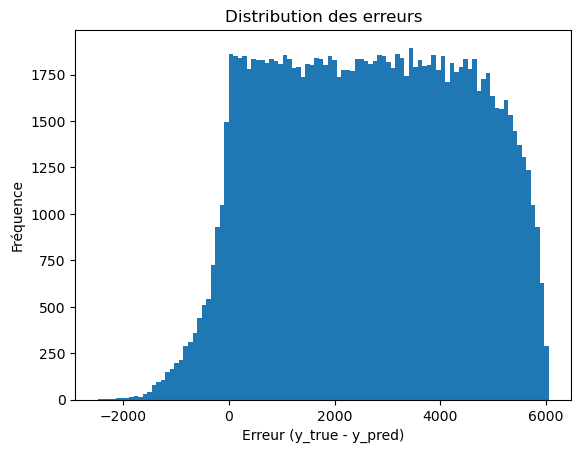

In [24]:
errors = y_val["y_true"].values - y_pred_val
plt.hist(errors, bins=100)
plt.title("Distribution des erreurs")
plt.xlabel("Erreur (y_true - y_pred)")
plt.ylabel("Fréquence")
plt.show()



NameError: name 'ax' is not defined

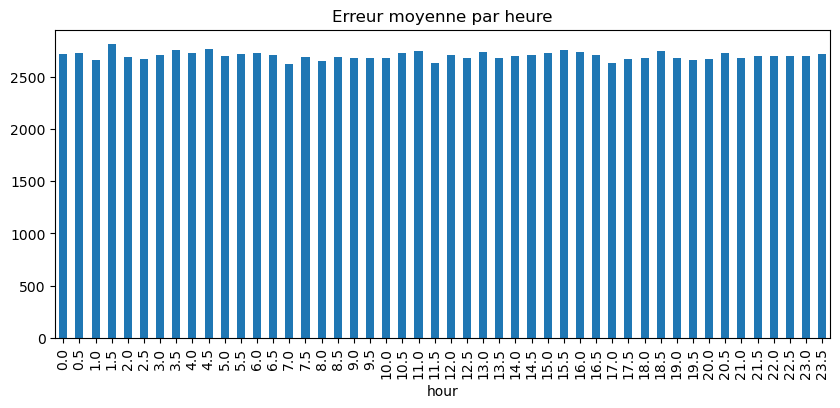

In [22]:
X_val['abs_error'] = np.abs(y_val["y_true"].values - y_pred_val)
X_val.groupby('hour')['abs_error'].mean().plot(kind='bar', figsize=(10,4))
plt.title("Erreur moyenne par heure")
ax.axhline(100, color='red', linestyle='--', linewidth=1)
plt.ylabel("MAE moyen")
plt.show()


In [ ]:
# recréer le bar plot et ajouter une ligne horizontale à y = 100
ax = X_val.groupby('hour')['abs_error'].mean().plot(kind='bar', figsize=(10,4))
ax.axhline(100, color='red', linestyle='--', linewidth=1)  # ligne horizontale
ax.axhline(80, color='red', linestyle='--', linewidth=1)  # ligne horizontale
ax.set_title("Erreur moyenne par heure")
ax.set_ylabel("MAE moyen")
plt.show()

In [ ]:
# recréer le bar plot et ajouter une ligne horizontale à y = 100
ax = X_val.groupby('weekday')['abs_error'].mean().plot(kind='bar', figsize=(10,4))
ax.axhline(100, color='red', linestyle='--', linewidth=1)  # ligne horizontale
ax.axhline(80, color='red', linestyle='--', linewidth=1)  # ligne horizontale
ax.set_title("Erreur moyenne par jour")
ax.set_ylabel("MAE moyen")
plt.show()

In [ ]:
y_val["y_true"].values